v5 + :
- xN
- scaling up (larger batch etc.)

Still Missing:
- Encoder
- Multi-head attention at the middle of decoder

Source:
- https://youtu.be/kCc8FmEb1nY?t=5580
- https://github.com/karpathy/ng-video-lecture/blob/master/bigram.py


<img src="../assets/transformer.png" width="600"/>

In [1]:
import os; os.chdir('..')
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch import nn
from torch.nn import functional as F
import math

from utils import *
from boring_utils.utils import init_graph, set_seed, get_device, cprint, tprint
from utils import add_to_class

In [4]:
init_graph()

# Hyperparameters

In [5]:
batch_size = 64  # how many independent sequences will we process in parallel?
block_size = 256  # what is the maximum context length for predictions?
# max_iters = 5000
max_iters = 4000
eval_interval = 500
learning_rate = 3e-4
device = get_device()
eval_iters = 200
n_embd = 384
n_embed = n_embd
n_head = 6
n_layer = 6
dropout = 0.2

print(f"device: {device}")

device: cuda


# Encode and Decode Funcion

In [6]:
input_file_path = './data/shakespeare_char/input.txt'

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
print("stoi:", stoi)
print("itos:", itos)

def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers

def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
stoi: {'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
itos: {0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q'

In [7]:
def test_decode(net, max_new_tokens=100):
    gen = net.generate(
            torch.zeros((1, 1), dtype=torch.long, device=device),
            max_new_tokens=max_new_tokens
        )
    print(gen)
    print(decode(gen[0].tolist()))

In [8]:
train_bin_path = './data/shakespeare_char/train.bin'
val_bin_path = './data/shakespeare_char/val.bin'

# train_tensor = torch.tensor(encode(data), dtype=torch.long) # convert to tensor

# torch.long is just an alias for torch.int64
# load the binary data
train_data = np.fromfile(train_bin_path, dtype=np.uint16)
val_data = np.fromfile(val_bin_path, dtype=np.uint16)

# convert to pytorch tensors
train_tensor = torch.from_numpy(train_data.astype(np.int64))
val_tensor = torch.from_numpy(val_data.astype(np.int64))

print(train_tensor.shape, train_tensor.dtype)
print(val_tensor.shape, val_tensor.dtype)


torch.Size([1003854]) torch.int64
torch.Size([111540]) torch.int64


# Attention

checkout `attention.ipynb`

In [9]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B, T, C = x.shape
        k = self.key(x)   # (B, T, hs)
        q = self.query(x) # (B, T, hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B, T, hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

## Simple Multi-Head Self-Attention

Communication part

In [10]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of each head is of size (batch, time-step, head size)
        #   in GPT2's implementation, it's batch, 12, time-step, 64 before concat
        #   after concat, it's batch, time-step, 768 (=12x64)
        # output of size (batch, time-step, channels)
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)  # NOTE: there is a external projection after the concat!!!
        out = self.dropout(out)
        return out

# Feed Forward Block

Per-token level

In [11]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


# LayerNorm

https://pytorch.org/docs/master/generated/torch.nn.LayerNorm.html#torch.nn.LayerNorm

In [12]:
# this is not used, only for reference
class LayerNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        xmean = x.mean(dim=1, keepdim=True)
        xvar = x.var(dim=1, keepdim=True)
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # norm to unit variance
        self.out = self.gamma * xhat + self.beta  # scale and shift
        return self.out 
    
    def parameters(self):
        return [self.gamma, self.beta]

In [13]:
# Let's test layernorm

module = LayerNorm1d(100)
x = torch.randn(32, 100)
x = module(x)
x.shape

torch.Size([32, 100])

# Transformer Block

In [14]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


# NN with Multihead-Attention

Deep NN start to have optimization issues, we need block + skip connection

In [15]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [16]:
m = GPTLanguageModel().to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

10.788929 M parameters


In [17]:
test_decode(m)

tensor([[ 0, 24, 32, 34, 60, 48, 51, 37, 29, 60, 50, 23, 19, 29, 46, 63,  1, 53,
          9, 16, 64, 38, 51, 35, 54, 19, 60,  3, 30, 19, 34, 56, 39, 20,  8,  5,
         11, 13, 27, 38,  9, 10, 25, 25, 53, 27, 46, 14, 23, 19, 22, 60, 28, 21,
          2, 30, 41, 40, 35, 25, 59, 38, 27, 28, 63, 27, 54, 39, 15, 17, 33, 33,
         25, 13, 23, 21, 21, 13, 20,  6, 28,  3, 61,  6, 19,  7,  2,  7, 55, 57,
         14,  7, 55, 16,  2, 15, 28, 63, 18, 32, 35]], device='cuda:0')

LTVvjmYQvlKGQhy o3DzZmWpGv$RGVraH.';AOZ3:MMoOhBKGJvPI!RcbWMuZOPyOpaCEUUMAKIIAH,P$w,G-!-qsB-qD!CPyFTW


# Training the NN

[torch.optim.Optimizer.zero_grad — PyTorch 2.0 documentation](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html)

In [18]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [19]:
loss_list = []

for steps in range(max_iters):
    if steps % eval_interval == 0 or iter == max_iters - 1:
        # in fp16 mode, we use autocast to automatically cast the data to half precision
        # ctx = nullcontext() if device == 'cpu' else torch.amp.autocast(device_type=device, dtype=ptdtype)
        losses = estimate_loss_np(m, eval_iters, train_data, val_data, block_size=block_size, batch_size=batch_size, device=device)
        # losses = estimate_loss(m)
        print(f"step: {steps}, train loss: {losses['train']:.4f}, val loss: {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch_np(train_data, block_size=block_size, batch_size=batch_size, device=device)

    # evaluate the loss
    logits, loss = m(xb, yb)
    # interesting...
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if steps % 200 == 0:
        loss_list.append(loss.item())


step: 0, train loss: 4.2077, val loss: 4.2065
step: 500, train loss: 1.7547, val loss: 1.9367
step: 1000, train loss: 1.4044, val loss: 1.6291
step: 1500, train loss: 1.2584, val loss: 1.5403
step: 2000, train loss: 1.1730, val loss: 1.4942
step: 2500, train loss: 1.0994, val loss: 1.4786
step: 3000, train loss: 1.0378, val loss: 1.4886
step: 3500, train loss: 0.9721, val loss: 1.5023
step: 4000, train loss: 0.9118, val loss: 1.5356
step: 4500, train loss: 0.8516, val loss: 1.5786


In [22]:
losses = estimate_loss_np(m, eval_iters, train_data, val_data, block_size=block_size, batch_size=batch_size, device=device)
# losses = estimate_loss(m)
print(f"Final train loss: {losses['train']:.4f}, val loss: {losses['val']:.4f}")

Final train loss: 0.7896, val loss: 1.6179


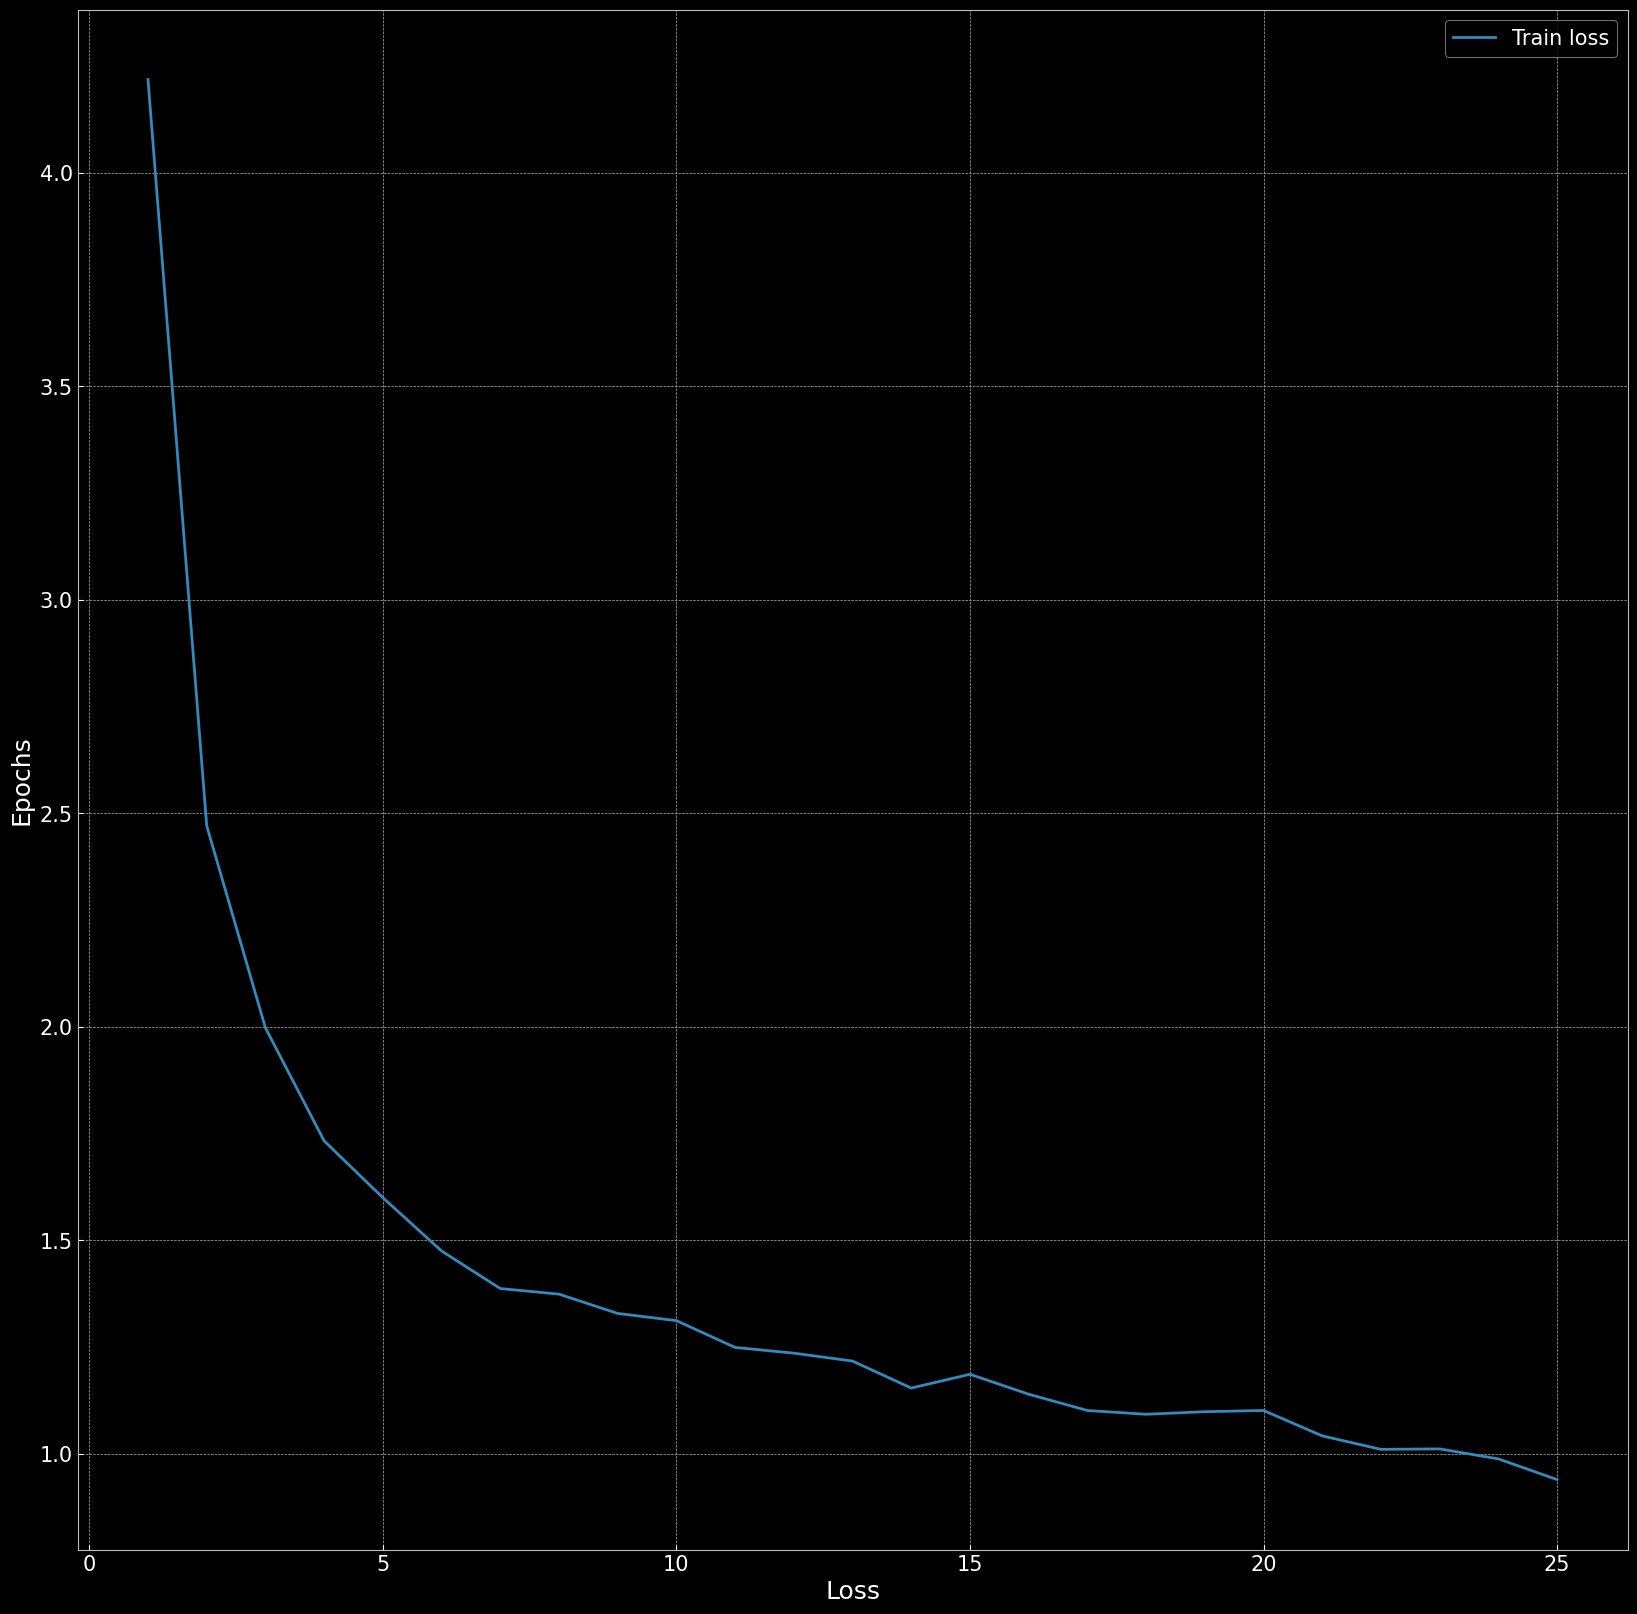

In [20]:
fig = plt.figure(figsize=(20, 20))
plt.plot(np.arange(1, len(loss_list) + 1), loss_list, label="Train loss")
plt.xlabel("Loss")
plt.ylabel("Epochs")
plt.legend(loc="upper right")

plt.show()

In [21]:
test_decode(m, 500)

tensor([[ 0, 20, 21, 31,  1, 54, 56, 47, 43, 57, 58,  1, 50, 53, 56, 42,  1, 39,
          1, 51, 39, 52,  5, 57,  1, 42, 43, 39, 42,  1, 39, 52, 42,  1, 57, 54,
         47, 58, 43,  8,  0, 20, 43, 56, 43,  1, 41, 39, 56, 43, 57,  1, 21,  1,
         56, 43, 51,  5, 42,  6,  1, 39,  1, 25, 53, 52, 58, 39, 45, 59, 43, 12,
          0,  0, 31, 43, 41, 53, 52, 42,  1, 25, 59, 56, 42, 43, 56, 43, 56, 10,
          0, 26, 53,  6,  1, 51, 39, 42, 39, 51,  6,  1, 52, 53,  1, 42, 53, 59,
         40, 58,  8,  0,  0, 15, 24, 13, 30, 17, 26, 15, 17, 10,  0, 35, 53, 59,
         50, 42,  1, 21,  1, 40, 43,  6,  1, 46, 39, 60, 43,  1, 52, 53,  1, 46,
         53, 54, 43,  1, 61, 47, 58, 46,  1, 58, 46, 43, 43,  6,  1, 21,  1, 57,
         43, 43,  0, 14, 59, 58,  1, 21,  1, 51, 43, 43, 58,  1, 51, 63,  1, 54,
         39, 56, 49, 50, 47, 44, 43, 10,  1, 40, 59, 58,  1, 58, 46, 53, 59,  5,
         50, 58, 43, 56,  5, 57, 58,  1, 51, 43,  0, 32, 46, 43,  1, 42, 53, 59,
         40, 50, 43, 58,  1,